### 회귀실습- 캐글 주택 가격: 고급 회귀 기법

미국 아이오와 주의 에임스 지방의 주택가격 정보

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

Q. 상기 데이터로 아래 사항에 유의하여 다음 사항을 수행하세요.

- LinearRegression, Ridge, Lasso를 이용하여 모델링 및 평가
    - 평가는 RMSLE(가격이 비싼 주택일수록 예측 결과 오류가 전체 오류에 미치는 비중이 높은 것을 상쇄하기 위하여 오류 값을 로그 변환하여 평가)
    - Null이 많은 컬럼과 불필요한 컬럼 삭제
    - 삭제하지 않은 숫자형 컬럼은 평균값으로 대체
    - 문자형 피처는 원-핫인코딩으로 변환
    - 피처별 회귀 계수 시각화 및 모델별 비교
    - 교차검증 수행 후 모델별 비교 - cross_val_score 이용
    - 각 모델별 평가 결과 비교 분석 및 개선 방안 기술
- Ridge와 Lasso 모델에 대하여 하이퍼 파라미터 튜닝하면서 최적 값 도출 후 학습/예측/평가 수행 및 회귀 계수 시각화
- 피처 데이터 세트의 분포도 검토 후 로그 변환 및 종속변수와 상관관계가 높은 독립변수의 이상치를 제거 후 학습/예측/평가 수행 및 시각화
- 회귀 트리 모델을 이용해 학습/예측/평가 수행 및 피처 중요도 시각화

In [33]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df= pd.read_csv('dataset/house_price.csv')
house_df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [34]:
house_df.shape

(1460, 81)

In [35]:
# 전체 피처 type 확인 
house_df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [36]:
# null 있는 columns
house_df.isnull().sum()[house_df.isnull().sum()>0].sort_values(ascending=False)

# >> 3분의1 이상이 null이면 drop  >> PoolQC, MiscFeature, Alley, Fence, FireplaceQu 
# 나머지는 평균값대체

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [37]:
# SalePrice 기준 상관관계 내림차순
house_df.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

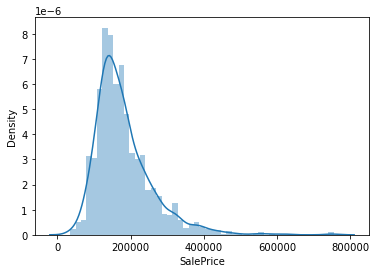

In [38]:
# 종속변수 분포 확인
sns.distplot(house_df['SalePrice'])

# >> 정규분포라고 하기 어려움 (왼쪽으로 쏠려있다)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

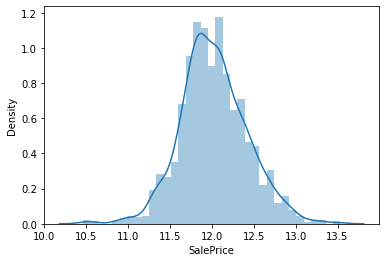

In [39]:
# 로그변환 - 정규분포 만들어주기
log_SalePrice = np.log1p(house_df['SalePrice'])

# 로그변환 후 분포 확인
sns.distplot(log_SalePrice)

# >> 정규분포! 

In [40]:
# 로그변환한 SalePrice 데이터프레임에 넣어주기

house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

In [41]:
# 필요없는 columns 삭제 (Id, null값 3분의1 이상이었던 columns)
house_df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu','Id'],axis=1,inplace=True)

In [43]:
# 나머지 columns에서  숫자형 columns null값 평균값으로 대체 
house_df.fillna(house_df.mean(),inplace=True)

# >> but, 문자형인 column에는 null값 존재

In [46]:
# 문자형 columns - one_hot 인코딩
house_df_oh= pd.get_dummies(house_df)

print('shape: ', house_df_oh.shape)
print('null 개수: ', house_df_oh.isnull().sum().sum())

shape:  (1460, 271)
null 개수:  0


In [52]:
# 이미 종속변수가 로그 변환 -> RMSE만 적용하면 RMSLE 자동 측정 
# 선형 회귀 모델

# RMSE 계산 사용자함수
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test,pred)
    rmse = np.sqrt(mse)
    print('{0} 로그변환된 RMSLE: {1}'.format(model.__class__.__name__,np.round(rmse,3)))
    return rmse

# get_rmse 사용자함수 사용해서 여러모델 RMSE값 반환
def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses



In [53]:
# 선형회귀모델 학습- 예측평가
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_oh['SalePrice']
X_features = house_df_oh.drop('SalePrice',axis=1)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, 
                                                    test_size=0.2, random_state=156)
# 모델별 학습
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()

models= [lr, ridge, lasso]

for model in models:
    model.fit(X_train,y_train)

# 사용자함수로 RMSE 반환 >> 다시한번 알아두기 : 로그변환된거라 RMSE => RMSLE 
get_rmses(models)

# >> Lasso만 0.176으로 lr,ridge 보다 성능이 떨어짐 >> 하이퍼파라미터 튜닝

LinearRegression 로그변환된 RMSLE: 0.132
Ridge 로그변환된 RMSLE: 0.128
Lasso 로그변환된 RMSLE: 0.176


[0.1318957657915436, 0.12750846334053045, 0.17628250556471395]

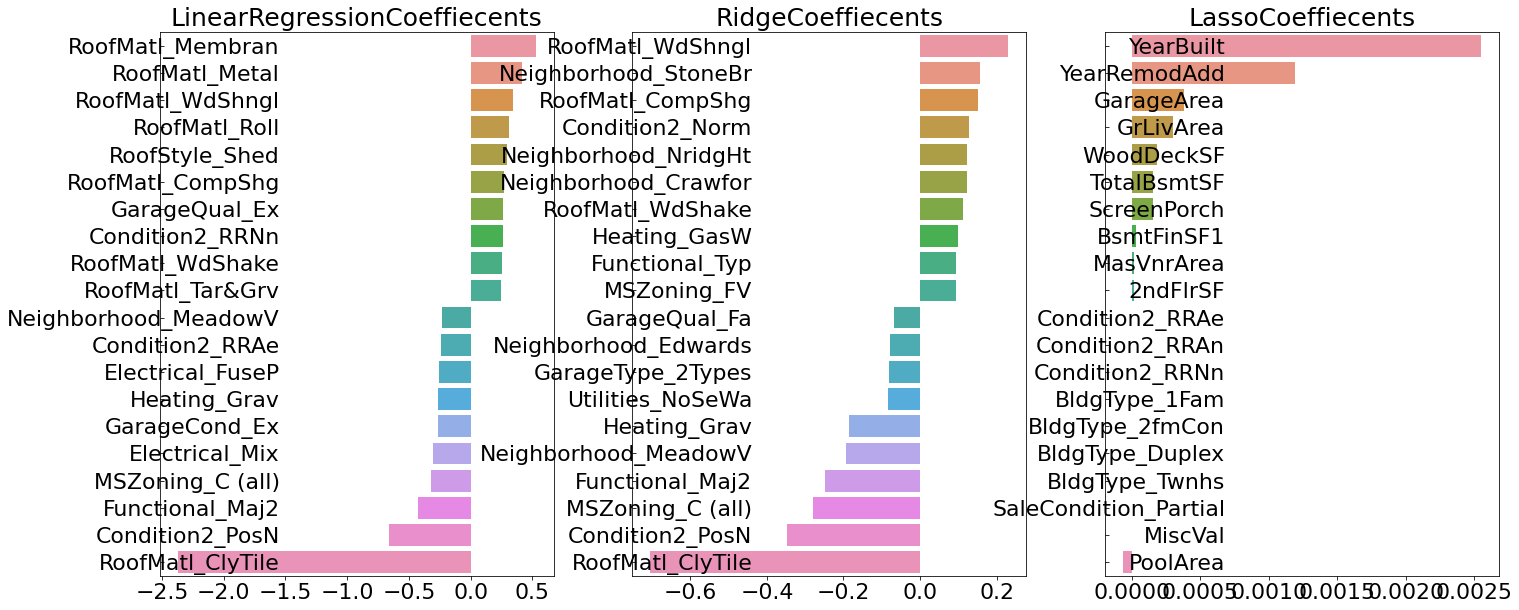

In [61]:
# feature별 회귀계수 시각화 (모델별 구성 feature 회귀계수)
# 상위10 + 하위10

# 모델별 회귀계수 사용자함수
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체 생성, index 컬럼명
    coef= pd.Series(model.coef_, index=X_features.columns) 
    
    # 상위10개 하위10개
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    
    return coef_high, coef_low

# 모델별 회귀계수 사용자함수 -> 시각화 사용자함수
def visualize_coefficient(models):
    # lr, ridge, lasso 3개 시각화 >> subplot 3개 컬럼 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    
    # models에서 lr, ridge, lasso 하나씩 뽑아서 회귀계수 뽑기
    for i, model in enumerate(models):
        # get_top_bottom_coef 사용자함수로 상하위 10개씩 회귀계수 뽑기
        coef_high, coef_low = get_top_bottom_coef(model)
        # 상위 하위 뽑은것 합치기
        coef_concat = pd.concat([coef_high, coef_low])
        
        # 순차적으로 ax subplot에 barchar로 나타내기 (시각화 설정)
        # (tick label 위치, font 크기 설정 --> 한 화면에 표현하려고)
        axs[i].set_title(model.__class__.__name__+ 'Coeffiecents', size=25) # 타이틀 설정
        axs[i].tick_params(axis="y",direction="in", pad=-120) # y축을 기준으로, 안쪽방향
        for label in (axs[i].get_xticklabels() + axs[i].get_yticklabels()):
            label.set_fontsize(22)  # x,y축에 들어가는 애들 폰트 크기설정
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax= axs[i])
        # x: 상위하위 values값 | y: index컬럼명 | [i]모델명 순서대로
        
        
# 사용자함수 사용해서 models 시각화
visualize_coefficient(models)

# >> Lasso만 회귀계수 값들이 적음 + YearBuilt만 엄청 큼  >> WHY? 

https://velog.io/@sset2323/05-10.-%ED%9A%8C%EA%B7%80-%EC%8B%A4%EC%8A%B5-%EC%BA%90%EA%B8%80-%EC%A3%BC%ED%83%9D-%EA%B0%80%EA%B2%A9-%EA%B3%A0%EA%B8%89-%ED%9A%8C%EA%B7%80-%EA%B8%B0%EB%B2%95

https://kurt7191.tistory.com/45

https://www.kaggle.com/natigmamishov/house-prices-prediction-with-lasso

In [ ]:
# lasso WHY?  >> 학습 데이터 분할이 잘못되었을 수도 있음
# cv(교차검증)로 평균 RMSE 측정해보기 

from sklearn.model_selection import cross_val_score

def get_avg_rmse